 # <center> <b>  STROKE PREDICTION </b> </center> 

* * * * *
This project aims to predict whether a patient is likely to get a stroke based on relevant information like gender, age, various diseases, and smoking status.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (12, 6)
sns.set(context="paper", font="monospace")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/TUTORED_PROJECT/Datasets/patient-characteristics-survey-pcs-2017-1.csv",  skipinitialspace=True)

In [ ]:
data.shape

(187192, 67)

## Data Preparation and EDA

In [ ]:
data.head()

,Survey Year,Program Category,Region Served,Age Group,Sex,Transgender,Sexual Orientation,Hispanic Ethnicity,Race,Living Situation,...,Unknown Insurance Coverage,No Insurance,Medicaid Insurance,Medicaid Managed Insurance,Medicare Insurance,Private Insurance,Child Health Plus Insurance,Other Insurance,Criminal Justice Status,Three Digit Residence Zip Code
0,2017,OUTPATIENT,CENTRAL NY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,...,NO,NO,YES,YES,NO,NO,NO,NO,NO,132
1,2017,SUPPORT,WESTERN REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",UNKNOWN,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,...,NO,NO,YES,UNKNOWN,YES,NO,NO,NO,UNKNOWN,146
2,2017,OUTPATIENT,CENTRAL NY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,...,NO,NO,YES,NO,NO,NO,NO,NO,NO,131
3,2017,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,...,NO,NO,YES,NO,YES,NO,NO,NO,NO,112
4,2017,OUTPATIENT,CENTRAL NY REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,...,YES,NO,NO,NOT APPLICABLE,NO,NO,NO,NO,NO,130


In [ ]:
# Removing the null values
data.dropna(how = 'any')

# Remove Unknown data from the dataframe
for column in data.columns:
    data = data[(data[column] != 'UNKNOWN')]

In [ ]:
data.shape

(64618, 67)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187192 entries, 0 to 187191
Data columns (total 67 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Survey Year                       187192 non-null  int64 
 1   Program Category                  187192 non-null  object
 2   Region Served                     187192 non-null  object
 3   Age Group                         187192 non-null  object
 4   Sex                               187192 non-null  object
 5   Transgender                       187192 non-null  object
 6   Sexual Orientation                187192 non-null  object
 7   Hispanic Ethnicity                187192 non-null  object
 8   Race                              187192 non-null  object
 9   Living Situation                  187192 non-null  object
 10  Household Composition             187192 non-null  object
 11  Preferred Language                187192 non-null  object
 12  Ve

### Target Feature EDA

Text(0.5, 1.0, 'Patients with Stroke')

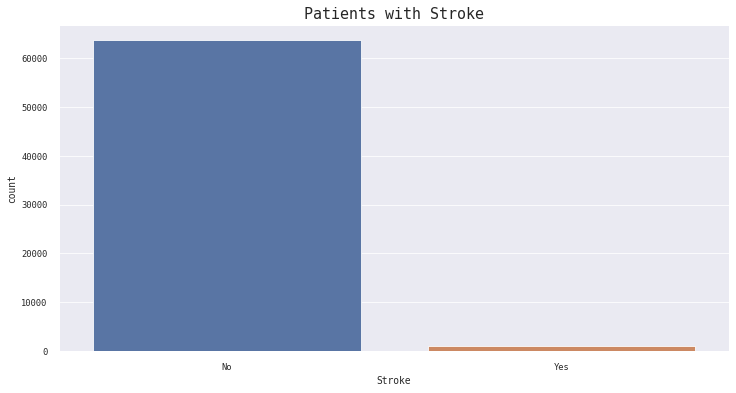

In [ ]:
sns.countplot('Stroke', data=data)
plt.xticks([0,1], ['No', 'Yes'])
plt.title('Patients with Stroke', size=15)


In [ ]:
perc = data['Stroke'].value_counts(normalize=True)*100
perc 

NO     98.503513
YES     1.496487
Name: Stroke, dtype: float64

In [ ]:
perc.keys()

Index(['NO', 'YES'], dtype='object')

Text(0.5, 1.0, 'Patients with Stroke Percentage')

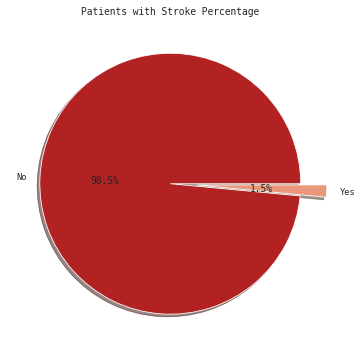

In [ ]:
labels = perc.keys() # get labels from perc
# autopct allows formatting percentage string
plt.pie(x=perc, autopct="%1.1f%%", explode=[0,0.2], labels=['No', 'Yes'], 
        pctdistance=0.5, shadow=True, colors=['firebrick','DarkSalmon'])
plt.title("Patients with Stroke Percentage")


**Observation:** Strokes are still relatively rare

### Features Correlation

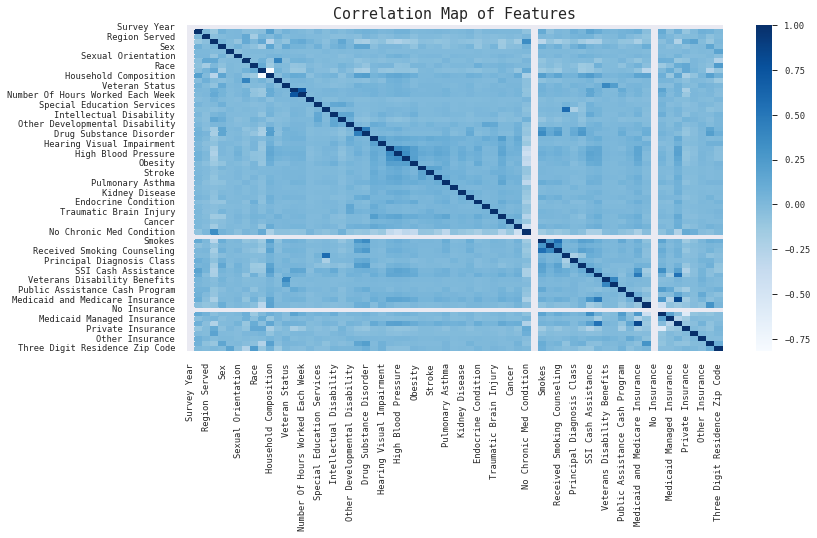

In [ ]:
from sklearn.preprocessing import LabelEncoder
#  Using Lable encoding
le = LabelEncoder()
en_df = data.apply(le.fit_transform)
en_df.head()
sns.heatmap(en_df.corr(), cmap='Blues', annot=False)
plt.title('Correlation Map of Features', size=15);

In [ ]:
data=en_df

In [ ]:
en_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64618 entries, 2 to 187191
Data columns (total 67 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Survey Year                       64618 non-null  int64
 1   Program Category                  64618 non-null  int64
 2   Region Served                     64618 non-null  int64
 3   Age Group                         64618 non-null  int64
 4   Sex                               64618 non-null  int64
 5   Transgender                       64618 non-null  int64
 6   Sexual Orientation                64618 non-null  int64
 7   Hispanic Ethnicity                64618 non-null  int64
 8   Race                              64618 non-null  int64
 9   Living Situation                  64618 non-null  int64
 10  Household Composition             64618 non-null  int64
 11  Preferred Language                64618 non-null  int64
 12  Veteran Status                 

## Model Training and Evaluation

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 49.7 MB/s 
     |████████████████████████████████| 81 kB 10.9 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 70.5 MB/s 
     |████████████████████████████████| 147 kB 49.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=09e40077067d8fa48274915e4c7ae72f4b13538adac1f5a5336d61aa0b2fee78
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ( f1_score, classification_report, 
                             confusion_matrix, roc_auc_score,
                             roc_curve, auc ) 

# load imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

# optuna for hyperparameter tuning 
import optuna

In [ ]:
y = en_df.Stroke
X = en_df.drop('Stroke', axis=1)
print(X.shape, y.shape)

(64618, 66) (64618,)


In [ ]:
counter = Counter(y)
print('Target class distribution: {}'.format(
    {k: v for k, v in counter.items()}))

Target class distribution: {0: 63651, 1: 967}


Dataset is highly imblanced, we use StratifiedKFold to split the data. StratifiedKFold splits a dataset randomly, although in such a way that maintains the same class distribution in each subset.

### Helper Functions

In [ ]:
def fit_predict(model, X, y, K, typ, plot=True, sampling=False, show=False):
    ''' Description
        -----------
        Train model specified on dataset using StratifiedKFold
        and resampling (optional)
        
        Parameters
        ----------
        model : sklearn model
            Machine learning model to be trained 
        X : pandas dataframe
          Training dataset
        y : pandas series 
          Target column, must have same number of observations with X
        K : int
          Number of folds for StratifiedKFold
        typ : str
          Training method, kept for model comparison
        plot : bool, optional
          Show roc-auc training plot (optional)
        sampling : bool, optional
          Use resample data for training 
        show: bool, optional
          Print number of observations after resampling
          
        Returns
        --------
        average confusion matrix, classification report, model name
        and roc curve
    '''
    
    # set initial scores
    scores = 0
    auc_scores = 0
    # set empty list to store predictions on test set
    test_oofs = []
    # get model name
    model_name = type(model).__name__
    # set a zero matrix of shape (2,2) for confusion matrix
    matrix = np.zeros((2, 2))
    # set up empty lists to extend true and predicted values
    originalclass = []
    predictedclass = []
    probclass = []
    train_accuracies, test_accuracies = [0.5], [0.5]

    # initiate StratifiedKFold
    kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if sampling:
            # oversampling and undersampling 
            # define pipeline
            over = SMOTE(sampling_strategy=0.1, random_state=1)
            under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
            steps = [('o', over), ('u', under)]
            pipeline = Pipeline(steps=steps)

            # resample train dataset
            X_train, y_train = pipeline.fit_resample(X_train, y_train)
        
        # training
        if model_name in ['VotingClassifier', 'RandomForestClassifier']:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train,
                      early_stopping_rounds=300,
                      eval_set=[(X_test, y_test)],
                      verbose=False)
            
        # predicting on test set
        pred = model.predict(X_test)
        prob = model.predict_proba(X_test)[:, 1]
        # predict on train test
        train_prob = model.predict_proba(X_train)[:, 1]
        # append y_test and pred list to original class and predicted class
        # lists respectively
        originalclass.extend(y_test)
        predictedclass.extend(pred)
        probclass.extend(prob)
        # get F1-score and roc_auc_score
        score = f1_score(y_test, pred, average='macro')
        roc = roc_auc_score(y_test, prob)
        train_roc = roc_auc_score(y_train, train_prob)
        # append roc-auc for train and test
        train_accuracies.append(train_roc)
        test_accuracies.append(roc)
        # take mean of scores
        scores += score/K
        auc_scores += roc/K
        test_oofs.append(pred)
        # sum confusion matrix of each fold to matrix
        matrix += confusion_matrix(y_test, pred)

        if i % 4 == 0:
            print('Fold {} F1-score: {}'.format(i+1, score))
            print('Fold {} ROC-AUC score: {}'.format(i+1, roc))
            print('='*45)

    print()
    print('Avg F1 score: {:.4f} '.format(scores))
    print('Avg ROC-AUC score: {:.4f} '.format(auc_scores))
    
    if show:
        counter = Counter(y_train)
        print('Target class distribution after sampling: {}'.format(
        {k: v for k, v in counter.items()})) 
        print()
        
    if plot:
        # plot train and test roc-auc
        plt.figure(figsize=(10, 5))
        plt.plot(train_accuracies, label="train roc-auc")
        plt.plot(test_accuracies, label="test roc-auc")
        plt.legend(loc="lower right", prop={'size': 12})
        plt.xticks(range(0, K, 5))
        plt.xlabel("fold", size=12)
        plt.ylabel("roc-auc", size=12)
        plt.show() 

    # get classification report
    report = classification_report(originalclass, predictedclass)
    curve_ = roc_curve(originalclass, probclass)

    # append results for comaprison
    Model.append(model_name)  # model name
    F1score.append(scores)  # f1-score
    AUCROC.append(auc_scores)  # roc_auc_score
    Resample.append(typ) # sampling style

    return matrix, report,  model, curve_

In [ ]:
def importance_plot(model, X, sample=''):
    ''' Description: Creates feature importance plot for a trained model
        Arguements: model - trained model on dataset
                    X - training dataset
                    sample - sampling method
    '''
    model_name = type(model).__name__
    if model_name in ['LogisticRegression', 'LinearRegression']:
        feat_imp = pd.DataFrame(sorted(zip(model.coef_[0], X.columns)),
                                columns=['Value', 'Feature'])
    else:
        feat_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)),
                                columns=['Value', 'Feature'])
    plt.figure(figsize=(20, 15))
    imp_data = feat_imp.sort_values(by="Value", ascending=False)
    sns.barplot(x="Value", y="Feature", data=imp_data.iloc[:50])
    plt.ylabel('Feature Importance Score')
    plt.title(model_name + ' ' + sample + ' Feature Importance', size=15)
    plt.show()

In [ ]:
def heat_map(model, matrix, labels, sample=''):
    ''' Description: Creates confusion matrix heatmap for a model
        Arguements: model - trained model
                    matrix - model confusion matrix
                    labels - list containing class labels [0, 1]
    '''
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,
                annot=True, fmt='g')
    plt.xlabel('Predicted label', size=10)
    plt.ylabel('True label', size=10)
    plt.title(type(model).__name__ + ' ' + sample + ' Confusion Matrix Heatmap', size=15)
    plt.show()

In [ ]:
# store results for result comparison
Model = []
F1score = []
AUCROC = [] 
Resample = []

Fold 1 F1-score: 0.49600311951647497
Fold 1 ROC-AUC score: 0.8835110449858451
Fold 5 F1-score: 0.5451735468807213
Fold 5 ROC-AUC score: 0.8521260096279736
Fold 9 F1-score: 0.4961995712336777
Fold 9 ROC-AUC score: 0.8161369267025199
Fold 13 F1-score: 0.4961995712336777
Fold 13 ROC-AUC score: 0.8704403085785647
Fold 17 F1-score: 0.5205883331985981
Fold 17 ROC-AUC score: 0.8919068624488892
Fold 21 F1-score: 0.5220340847168689
Fold 21 ROC-AUC score: 0.8360999710588334
Fold 25 F1-score: 0.5212948517940718
Fold 25 ROC-AUC score: 0.8988144457766569

Avg F1 score: 0.5131 
Avg ROC-AUC score: 0.8610 


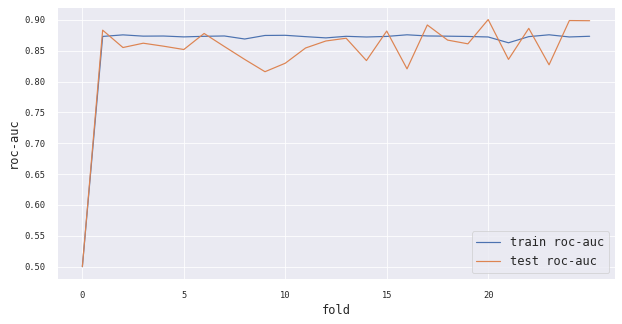

In [ ]:
xgboost = xgb.XGBClassifier(eval_metric='logloss')
xgb_matrix, xgb_report, xgb_1, xgb_curve = fit_predict(xgboost, X, y, 25, 'actual')

Feature importance plot

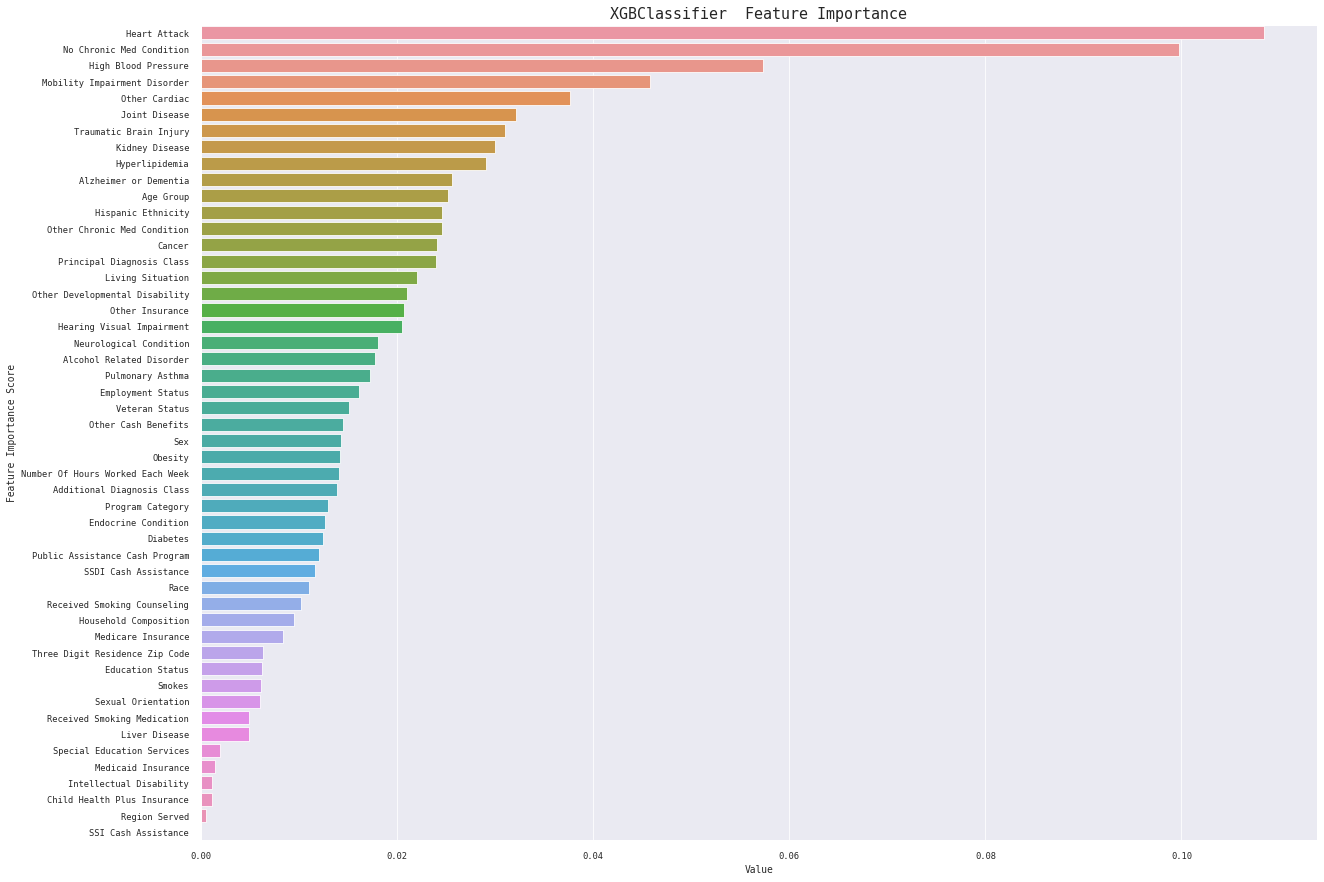

In [ ]:
importance_plot(xgb_1, X)

Confusion matrix heatmap

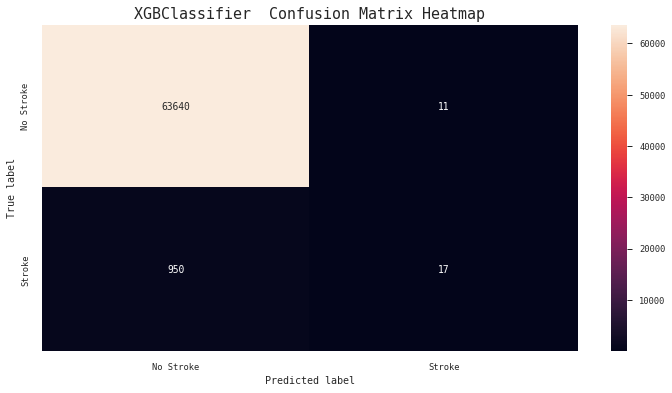

In [ ]:
heat_map(xgb_1, xgb_matrix, ['No Stroke', 'Stroke'])

In [ ]:
print(xgb_report) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63651
           1       0.61      0.02      0.03       967

    accuracy                           0.99     64618
   macro avg       0.80      0.51      0.51     64618
weighted avg       0.98      0.99      0.98     64618



ROC Curve

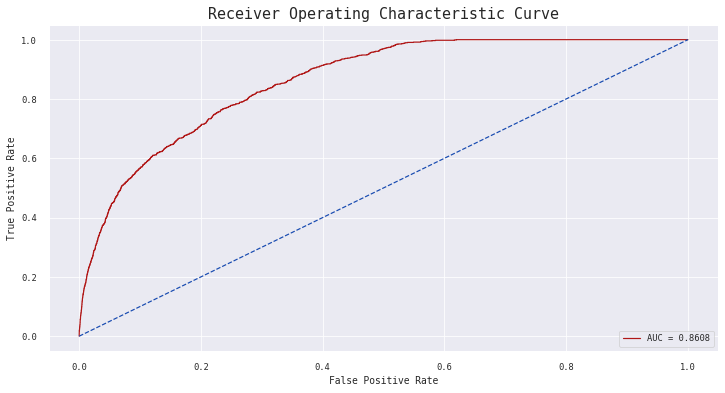

In [ ]:
# Roc Curve
fpr, tpr, _ = xgb_curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

#### Hyperparameter tuning

In [ ]:
def objective(trial):
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(X, y):
        train_x, val_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, val_y = y.iloc[train_index], y.iloc[valid_index]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    accuracy = roc_auc_score(val_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-21 12:31:34,954] A new study created in memory with name: no-name-4f0b390e-c356-4f32-b690-7cfef21dec65
[I 2022-11-21 12:31:38,149] Trial 0 finished with value: 0.7984722767740247 and parameters: {'n_estimators': 4279, 'learning_rate': 0.04519508106154205, 'booster': 'dart', 'lambda': 0.012735257398471384, 'alpha': 1.787290482979571e-08, 'max_depth': 8, 'eta': 1.4769457135931364e-08, 'gamma': 0.00046832841078117845, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.0485776234274547e-05, 'skip_drop': 3.905213527999607e-08}. Best is trial 0 with value: 0.7984722767740247.
[I 2022-11-21 12:31:39,009] Trial 1 finished with value: 0.5918884197433883 and parameters: {'n_estimators': 2155, 'learning_rate': 0.030612424973637066, 'booster': 'gbtree', 'lambda': 3.016784491574081e-08, 'alpha': 0.00027601293459830653, 'max_depth': 1, 'eta': 1.695671270241972e-06, 'gamma': 0.0012198409691380051, 'grow_policy': 'lossguide'}. Best is trial 0 w

Number of finished trials:  100
Best trial:
  Value: 0.8080559374181723
  Params: 
    n_estimators: 1394
    learning_rate: 0.09016983312610642
    booster: gbtree
    lambda: 0.0004276642401259364
    alpha: 4.982010322456671e-05
    max_depth: 9
    eta: 0.3667619047244212
    gamma: 0.0020809637576022604
    grow_policy: lossguide


Use paramters from hyperameter tuning

In [ ]:
op_xgboost = xgb.XGBClassifier(n_estimators = 1394,
                               learning_rate = 0.09016983312610642,
                               booster = 'gbtree',
                               reg_lambda = 0.0004276642401259364  ,
                               alpha =  4.982010322456671e-05,
                               max_depth = 9,
                               eta = 0.3667619047244212,
                               gamma = 0.0020809637576022604,
                               grow_policy = 'lossguide')   

Fold 1 F1-score: 0.5212962962962963
Fold 1 ROC-AUC score: 0.833002707003079
Fold 5 F1-score: 0.5873975809598128
Fold 5 ROC-AUC score: 0.8037142224102161
Fold 9 F1-score: 0.5212962962962963
Fold 9 ROC-AUC score: 0.8165095574757789
Fold 13 F1-score: 0.5451735468807213
Fold 13 ROC-AUC score: 0.8558724595645255
Fold 17 F1-score: 0.5427082341094344
Fold 17 ROC-AUC score: 0.8310371220818982
Fold 21 F1-score: 0.5220340847168689
Fold 21 ROC-AUC score: 0.8457694215901105
Fold 25 F1-score: 0.545172139843107
Fold 25 ROC-AUC score: 0.8566998801008806

Avg F1 score: 0.5338 
Avg ROC-AUC score: 0.8302 


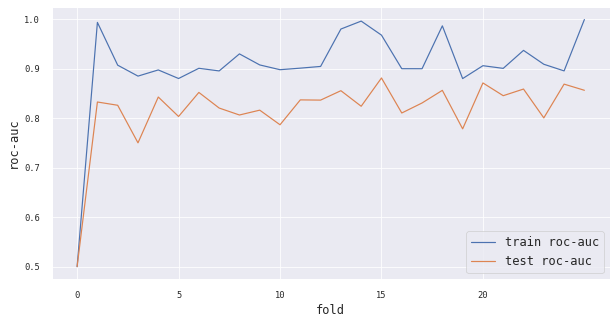

In [ ]:
xgb_matrix_op, xgb_report_op, xgb_op, xgb_curve_op = fit_predict(op_xgboost, X, y, 25, 'tuned')

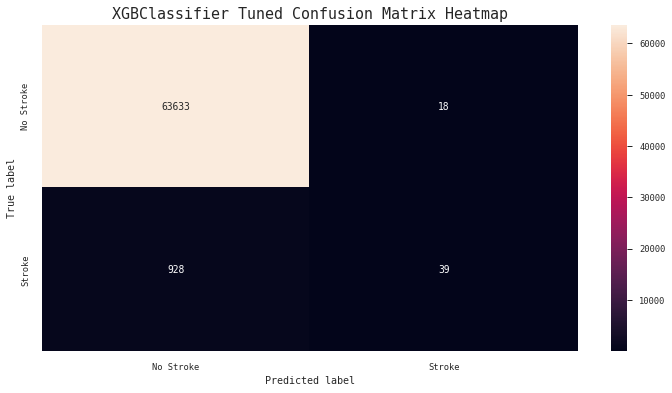

In [ ]:
heat_map(xgb_op, xgb_matrix_op, ['No Stroke', 'Stroke'], 'Tuned')

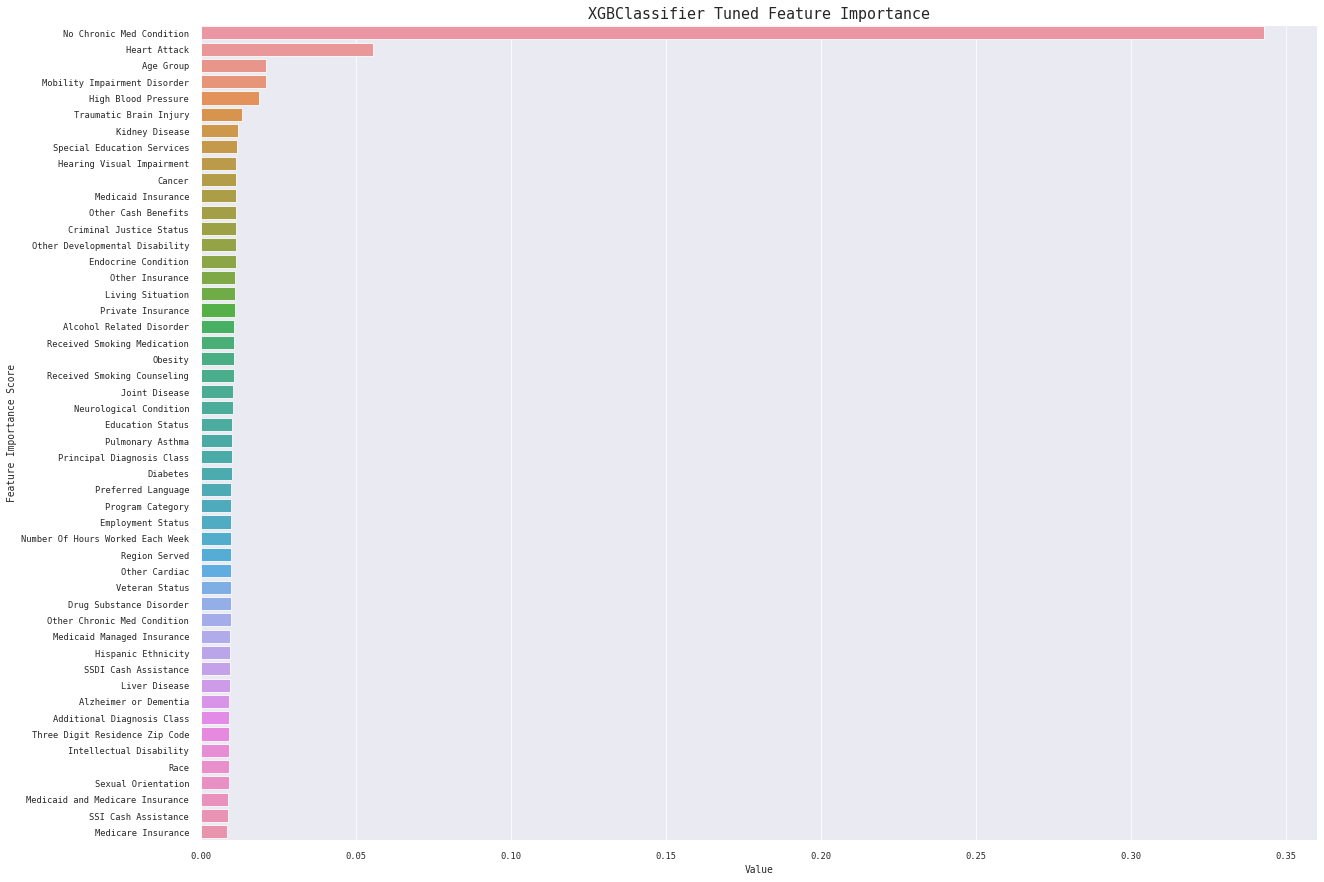

In [ ]:
importance_plot(xgb_op, X, 'Tuned')

In [ ]:
print(xgb_report_op)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63651
           1       0.68      0.04      0.08       967

    accuracy                           0.99     64618
   macro avg       0.83      0.52      0.53     64618
weighted avg       0.98      0.99      0.98     64618



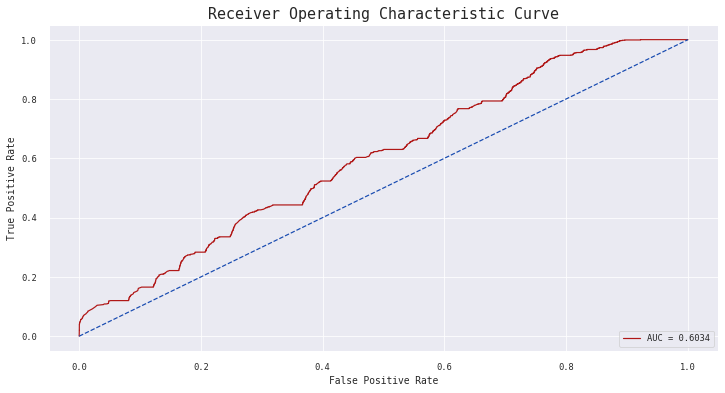

In [ ]:
# Roc Curve
fpr, tpr, _ = xgb_curve_op
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

### Combine Oversampling and Random Undersampling

Since the dataset is imbalanced, we try to tackle this imbalance by oversampling the minority class and undersampling the majority class using random undersampling. Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class.

Train and evaluate using resampled data

Fold 1 F1-score: 0.5188370188370188
Fold 1 ROC-AUC score: 0.7824478746926209
Fold 5 F1-score: 0.5119054893853391
Fold 5 ROC-AUC score: 0.7776048905271216
Fold 9 F1-score: 0.5083152484032936
Fold 9 ROC-AUC score: 0.7735915563881
Fold 13 F1-score: 0.5239476521117564
Fold 13 ROC-AUC score: 0.7668640602654743
Fold 17 F1-score: 0.5172047153773301
Fold 17 ROC-AUC score: 0.7955062742965335
Fold 21 F1-score: 0.519834078289312
Fold 21 ROC-AUC score: 0.8236449332285939
Fold 25 F1-score: 0.5090093430223936
Fold 25 ROC-AUC score: 0.8174225823789639

Avg F1 score: 0.5142 
Avg ROC-AUC score: 0.7845 
Target class distribution after sampling: {0: 12220, 1: 6110}



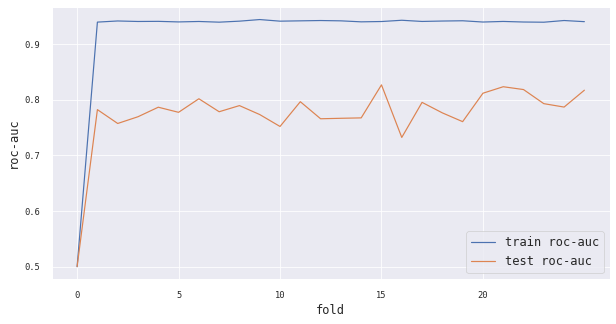

In [ ]:
xgb_matrix_sample, xgb_report_sample, xgb_sample, xgb_curve_sample = fit_predict(xgboost, X, y, 
                                                                                25, 'smote',
                                                                                sampling=True,
                                                                                show=True)

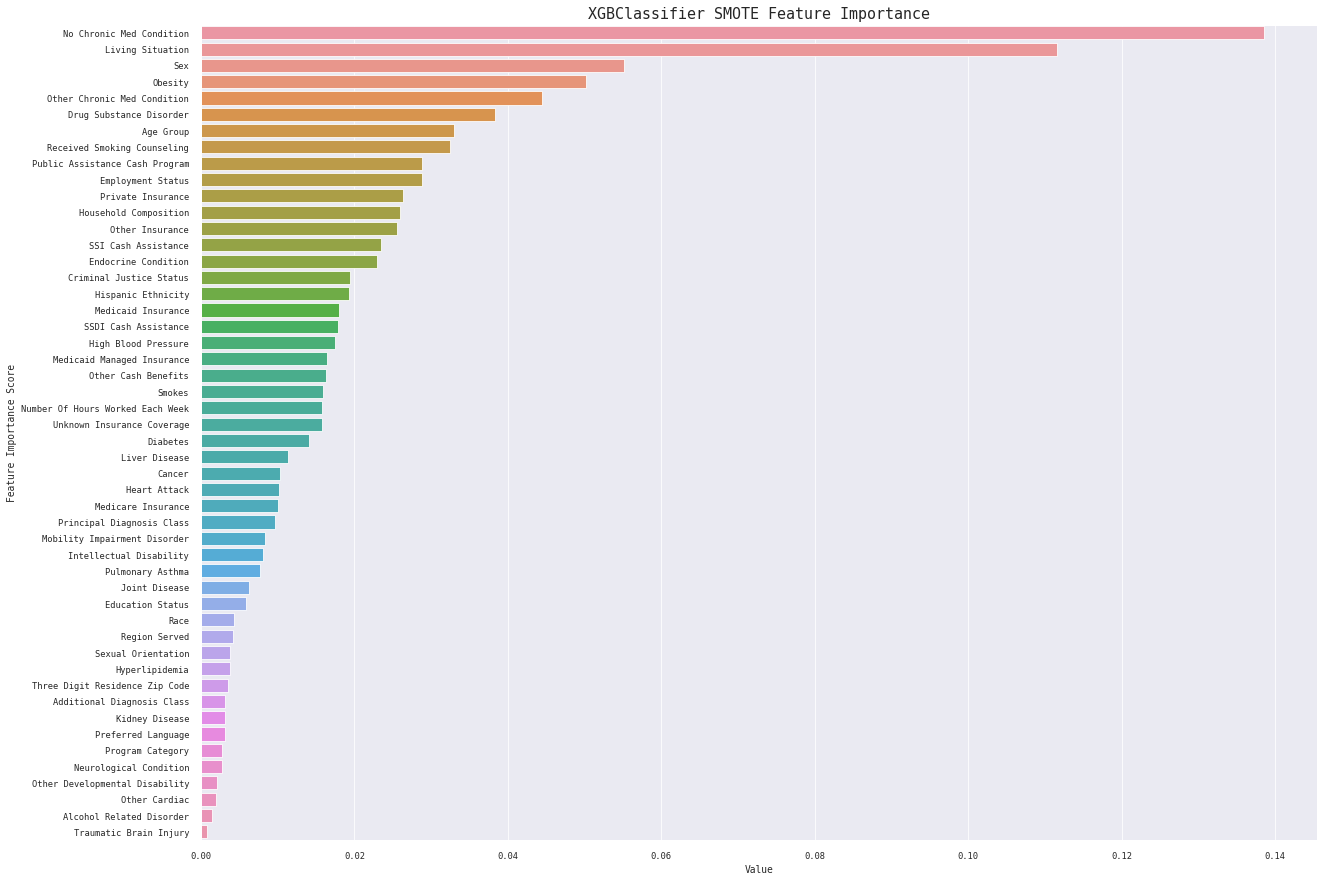

In [ ]:
importance_plot(xgb_sample, X, 'SMOTE') 

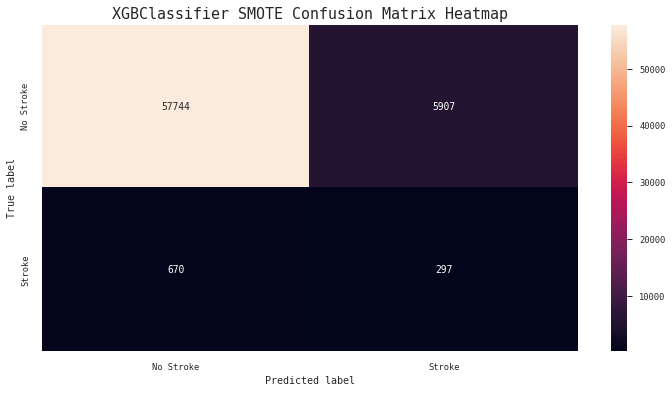

In [ ]:
heat_map(xgb_sample, xgb_matrix_sample, ['No Stroke', 'Stroke'], 'SMOTE')

In [ ]:
print(xgb_report_sample)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     63651
           1       0.05      0.31      0.08       967

    accuracy                           0.90     64618
   macro avg       0.52      0.61      0.51     64618
weighted avg       0.97      0.90      0.93     64618



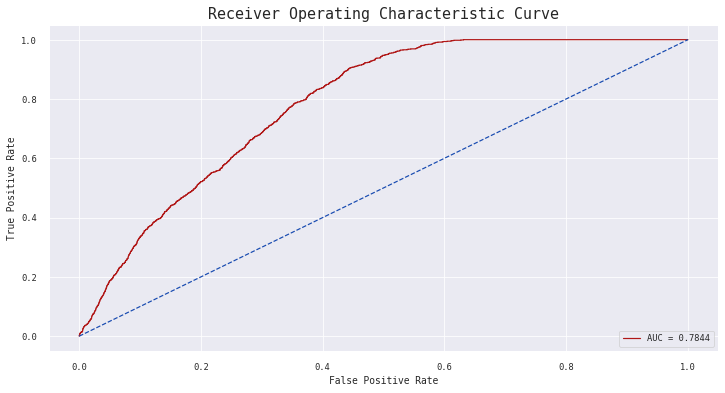

In [ ]:
# Roc Curve
fpr, tpr, _ = xgb_curve_sample
roc_auc = auc(fpr, tpr) 

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

#### Hyperparameter Tuning

In [ ]:
# oversampling and undersampling 
# define pipeline
over = SMOTE(sampling_strategy=0.1, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

def objective(trial):
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(X, y):
        train_x, val_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, val_y = y.iloc[train_index], y.iloc[valid_index]
        
        # resample train dataset
        train_x, train_y = pipeline.fit_resample(train_x, train_y)
            
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    accuracy = roc_auc_score(val_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-21 13:26:34,368] A new study created in memory with name: no-name-909734b7-4c73-4789-9f6e-ada61f41ebb7
[I 2022-11-21 13:26:36,672] Trial 0 finished with value: 0.5670479837653837 and parameters: {'n_estimators': 4191, 'learning_rate': 0.012216778025027703, 'booster': 'gblinear', 'lambda': 0.002966074286564399, 'alpha': 0.047757631291061274}. Best is trial 0 with value: 0.5670479837653837.
[I 2022-11-21 13:26:39,445] Trial 1 finished with value: 0.7284212162869861 and parameters: {'n_estimators': 2225, 'learning_rate': 0.07976246160499634, 'booster': 'dart', 'lambda': 0.00033380030762699043, 'alpha': 9.135754662015002e-05, 'max_depth': 6, 'eta': 0.13245135841789507, 'gamma': 0.0010942035064242235, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.4229401591984451e-05, 'skip_drop': 0.5969416820668741}. Best is trial 1 with value: 0.7284212162869861.
[I 2022-11-21 13:26:42,331] Trial 2 finished with value: 0.7264262568735271 and p

Number of finished trials:  100
Best trial:
  Value: 0.7661814283843938
  Params: 
    n_estimators: 2225
    learning_rate: 0.09813697556050799
    booster: gbtree
    lambda: 0.1735637575695062
    alpha: 1.1353344187204492e-07
    max_depth: 9
    eta: 5.529008372542022e-06
    gamma: 2.7711201281268545e-05
    grow_policy: depthwise


In [ ]:
op_xgboost_t = xgb.XGBClassifier(n_estimators = 2225,
    learning_rate =  0.09813697556050799,
    booster = 'gbtree' ,
    reg_lambda = 0.1735637575695062,
    alpha =   1.1353344187204492e-07,
    max_depth = 9 ,
    eta =  5.529008372542022e-06 ,
    gamma =  2.7711201281268545e-05 , 
    grow_policy =  'depthwise',
   )   

Fold 1 F1-score: 0.5459944109197512
Fold 1 ROC-AUC score: 0.7623964239420409
Fold 5 F1-score: 0.5423914367611621
Fold 5 ROC-AUC score: 0.7671778112954584
Fold 9 F1-score: 0.5682387825690682
Fold 9 ROC-AUC score: 0.8076183025330907

Avg F1 score: 0.5495 
Avg ROC-AUC score: 0.7942 
Target class distribution after sampling: {0: 11314, 1: 5657}



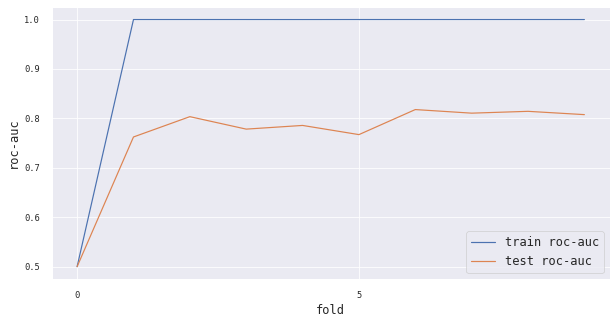

In [ ]:
xgb_matrix_t, xgb_report_t, xgb_t, xgb_curve_t = fit_predict(op_xgboost_t, X, y, 9, 'smote tuned',
                                                            sampling=True, show=True)

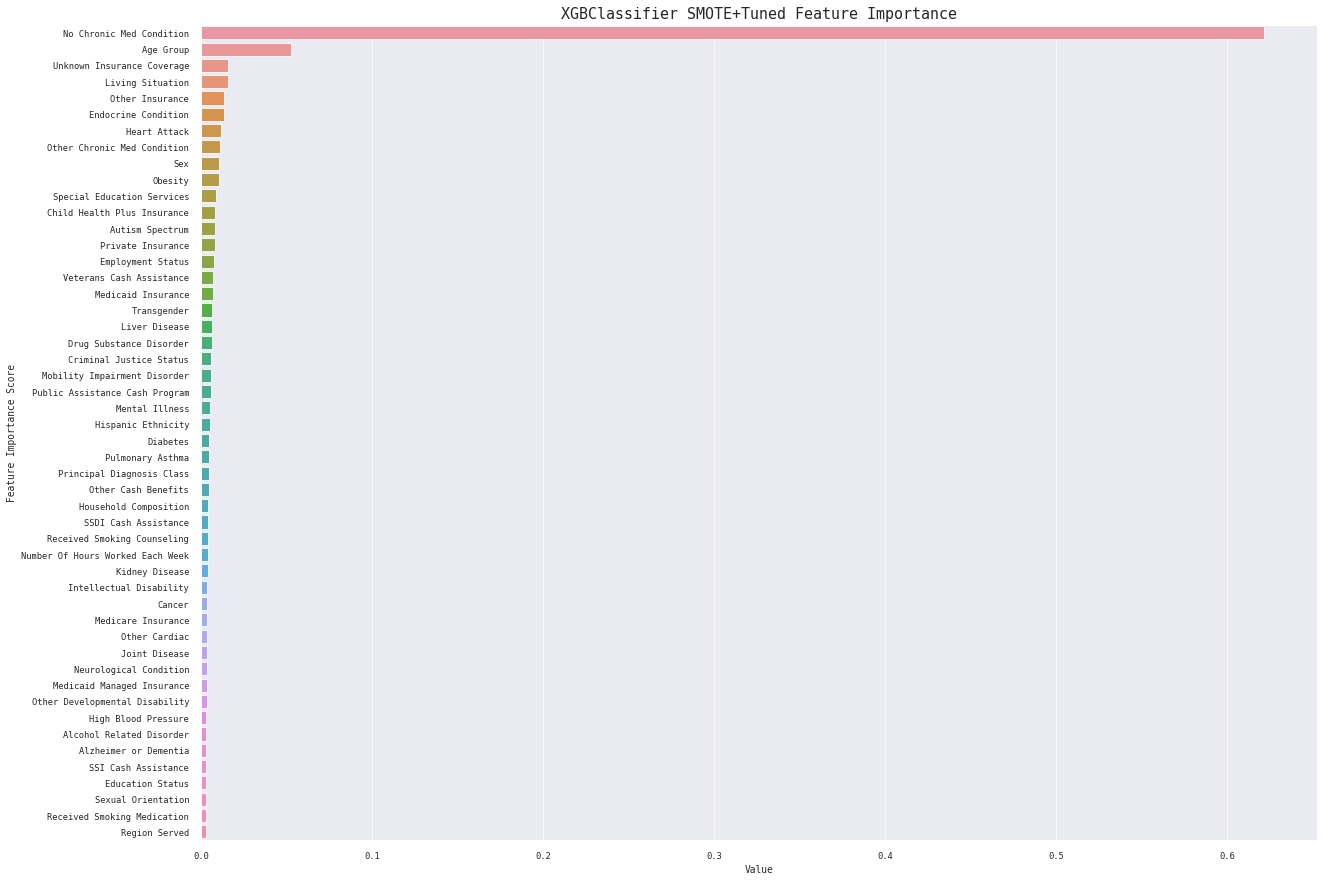

In [ ]:
importance_plot(xgb_t, X, 'SMOTE+Tuned')

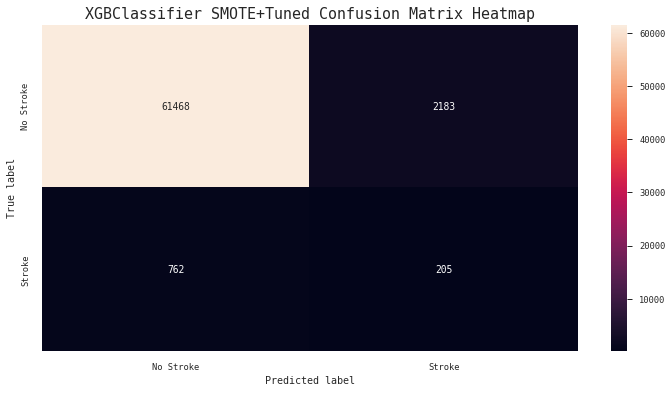

In [ ]:
heat_map(xgb_t, xgb_matrix_t, ['No Stroke', 'Stroke'], 'SMOTE+Tuned')

In [ ]:
print(xgb_report_t)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     63651
           1       0.09      0.21      0.12       967

    accuracy                           0.95     64618
   macro avg       0.54      0.59      0.55     64618
weighted avg       0.97      0.95      0.96     64618



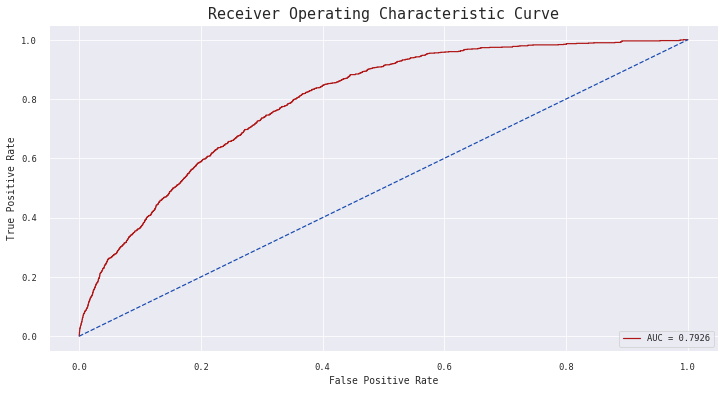

In [ ]:
# Roc Curve
fpr, tpr, _ = xgb_curve_t
roc_auc = auc(fpr, tpr) 

plt.plot(fpr, tpr, color = '#b01717', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic Curve', size=15); 

## Compare Results

In [ ]:
eval_df = pd.DataFrame({'model':Model,
                        'resample':Resample,
                        'f1-score':F1score,
                        'AUC-ROC':AUCROC})
eval_df 

,model,resample,f1-score,AUC-ROC
0,XGBClassifier,actual,0.513063,0.861007
1,XGBClassifier,tuned,0.533787,0.830249
2,XGBClassifier,smote,0.514247,0.784460
3,XGBClassifier,smote tuned,0.549455,0.794165


Text(0.5, 0.98, 'XGBoost ROC-AUC Score Comaprison')

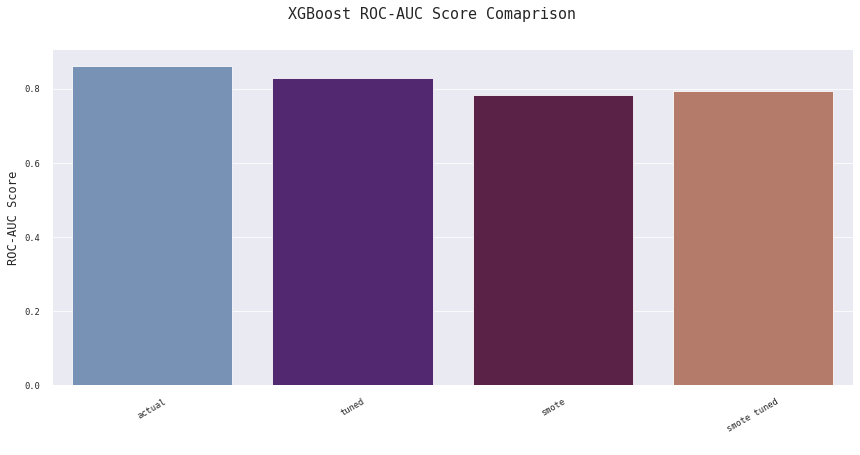

In [ ]:
g = sns.FacetGrid(eval_df, size=6, aspect=2)
g.map(sns.barplot, 'resample', 'AUC-ROC', palette='twilight', 
      order=['actual', 'tuned', 'smote', 'smote tuned'])
g.set_xticklabels(rotation=30) 
g.set_xlabels(' ') 
g.set_ylabels('ROC-AUC Score', size=12)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('XGBoost ROC-AUC Score Comaprison', size=15)


Text(0.5, 0.98, 'XGBoost F1 Score Comaprison')

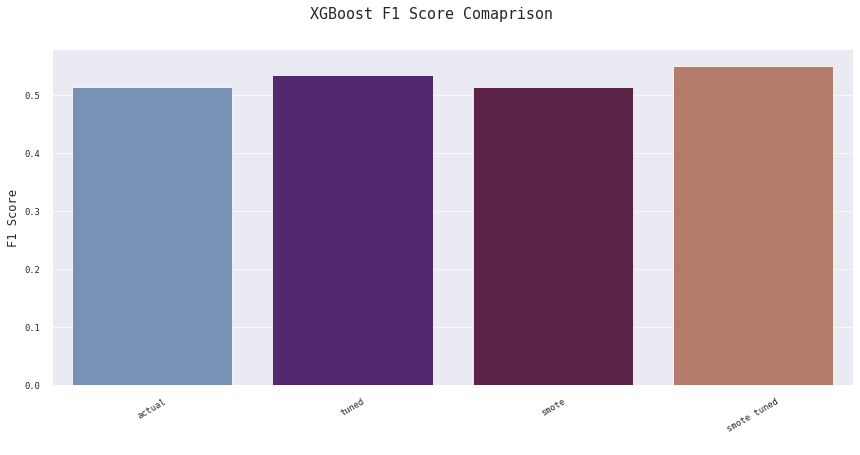

In [ ]:
g = sns.FacetGrid(eval_df, size=6, aspect=2)
g.map(sns.barplot, 'resample', 'f1-score', palette='twilight', 
      order=['actual', 'tuned', 'smote', 'smote tuned'])
g.set_xticklabels(rotation=30) 
g.set_xlabels(' ') 
g.set_ylabels('F1 Score', size=12)
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle('XGBoost F1 Score Comaprison', size=15)


In [ ]:
df = data.loc[:, ['Hyperlipidemia','Employment Status','Drug Substance Disorder','Diabetes','Public Assistance Cash Program','Obesity','Smokes','Other Chronic Med Condition','Sex','SSI Cash Assistance','Medicaid Managed Insurance','Household Composition', 'Race', 'Program Category', 'Heart Attack', 'Additional Diagnosis Class', 'Education Status', 'Region Served', 'Three Digit Residence Zip Code']]


We would use the tuned model with SMOTE. F1-score and ROC-AUC score is good, it classifies the minority class well and does not overfit on the data.

Save the model for use 

In [ ]:
import pickle

# pickle.dump(xgb_t, open('model/stroke_smote_tuned.pkl', 'wb'))  

In [ ]:
data[255:256]

,Survey Year,Program Category,Region Served,Age Group,Sex,Transgender,Sexual Orientation,Hispanic Ethnicity,Race,Living Situation,...,Unknown Insurance Coverage,No Insurance,Medicaid Insurance,Medicaid Managed Insurance,Medicare Insurance,Private Insurance,Child Health Plus Insurance,Other Insurance,Criminal Justice Status,Three Digit Residence Zip Code
555,0,1,2,0,1,1,4,0,2,0,...,1,0,0,1,0,0,0,0,0,18


Test saved model

In [ ]:
load_clf = pickle.load(open('model/stroke_smote_tuned.pkl', 'rb'))
# Apply model to make predictions
prediction = load_clf.predict(X[255:256])
prediction_proba = load_clf.predict_proba(X[255:256])
print(prediction, prediction_proba, prediction_proba.max()) 

[0] [[0.98248094 0.01751908]] 0.98248094
